# ***MAIN FUNCTIONALITY***

In [39]:
from dataclasses import dataclass, field
from typing import List, Dict
from functools import lru_cache

from WiseWattage.jrc_tmy import get_jrc_tmy
from WiseWattage.solar_pv_model import calc_solar_model, combine_array_results
from WiseWattage.solar_pv_model import total_array_results, pv_stats, pv_stats_grouped, SummaryGrouped

import logging

import pandas as pd
import plotly.express as px
import plotly.io as pio


import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logger = logging.getLogger()  # Get the root logger
logger.setLevel(logging.INFO)  # Set the default log level

# Create a file handler for writing logs to a file
file_handler = logging.FileHandler('WattSunandHomes.log', mode='a')
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

# Create a stream handler for writing logs to the terminal
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

# Add both handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(stream_handler)


def main():
    pass

@dataclass
class Site:
    name: str = ""
    address: str = ""
    client: str = ""
    latitude: float = 54.60452
    longitude: float = -5.92860
    tmz_hrs_east: int = 0
    tmy_data: pd.DataFrame = field(default=None, init=False)

    def __post_init__(self):
        self.tmy_data = get_jrc_tmy_cached(self.latitude, self.longitude)
        logging.info(f'TMY data obtained for: {self.latitude}, longitude: {self.longitude}')
        logging.info("*******************")

@lru_cache(maxsize=None)  # Cache TMY results
def get_jrc_tmy_cached(latitude, longitude):
    logging.info(f'Fetching TMY data for latitude: {latitude}, longitude: {longitude}')
    return get_jrc_tmy(latitude, longitude)


@dataclass
class SolarPVArray:
    pv_kwp: float = 1
    surface_pitch: float = 35
    surface_azimuth: float = 0
    lifespan: float = 25
    pv_eol_derating: float = 0.88
    cost_per_kWp: float = 1250
    electrical_eff: float = 0.21
    cell_temp_coeff: float = -0.0035
    transmittance_absorptance: float = 0.9
    refraction_index: float = 0.1
    cell_NOCT: float = 42
    ambient_NOCT: float = 20
    e_poa_NOCT: float = 800
    e_poa_STC: float = 1000
    cell_temp_STC: float = 25


@dataclass
class SolarPVModel:
    site: Site
    arrays: List[SolarPVArray]
    models: List[Dict] = field(default_factory=list)
    all_models: pd.DataFrame = field(default=None, init=False)
    combined_model: pd.DataFrame = field(default=None, init=False)
    summary: pd.DataFrame = field(default=None, init=False)
    summary_grouped: SummaryGrouped = field(default=None, init=False)
    albedo: float = 0.2
    timestep: int = 60

    def __post_init__(self):
        self.model_solar_pv()
        self.summary = pv_stats(self.all_models, self.arrays)
        logging.info("Model statistical analysis completed.")
        self.summary_grouped = pv_stats_grouped(self.all_models)
        logging.info("Model statistical grouping completed.")
        logging.info("*******************")

    # Function to run solar PV model and save to results, all_models and combined_model
    def model_solar_pv(self):
        logging.info("*******************")
        logging.info("Starting model calculations for SolarPVModel.")
        logging.info("*******************")
        models = []
        for array in self.arrays:
            log_message = (f"Simulating model for {array.pv_kwp}kWp, {array.surface_pitch} degrees pitch "
               f"& azimuth at {array.surface_azimuth} degrees WoS")
            logging.info(log_message)
            result = calc_solar_model(self.site.tmy_data, self.site.latitude, self.site.longitude,
                                      array.pv_kwp, array.surface_pitch, array.surface_azimuth,
                                      array.lifespan, array.pv_eol_derating, array.electrical_eff,
                                      self.albedo, array.cell_temp_coeff, array.transmittance_absorptance,
                                      array.refraction_index, array.cell_NOCT, array.ambient_NOCT,
                                      array.e_poa_NOCT, array.e_poa_STC, array.cell_temp_STC, self.timestep,
                                      self.site.tmz_hrs_east)
            models.append({"array_specs": array, "model_result": result})
        logging.info("*******************")
        logging.info("Model calculations completed.")
        self.models = models
        self.all_models = combine_array_results(models)
        logging.info("Model data aggregated.")
        self.combined_model = total_array_results(models)
        logging.info("Model data summary complete.")
        logging.info("*******************")

    def save_model_csv(self):
        if self.all_models is not None:
            self.all_models.to_csv(f"Solar_Modelling_{self.site.name}_Combined.csv")
            logging.info("Model data saved to csv file completed.")
        logging.info("*******************")

    # Returns model for # array at # index location in results
    def array_model(self, n):
        try:
            return self.models[n]["model_result"]
        except IndexError:
            return f"There was no model at index {n}, check the number of arrays modelled and try again."


    def model_summary_html_export(self, freq=None, grouped=True):
        org_col_grouped = ["PV_Gen_kWh_Total", "Panel_POA_kWm2_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total",
                            "ET_HRad_kWm2_Total", "E_Beam_kWm2_Total", "E_Diffuse_kWm2_Total", "E_Ground_kWm2_Total",
                            "Cell_Temp_C_Avg", "T2m"]
        new_col_grouped = ["PV Generation (kWh)", "POA Radiation (kWh)", "AOI Losses (kWh)", "Thermal Losses (kWh)",
                   "ET Horizontal Radiation", "Beam Radiation (kWh)", "Diffuse Radiation (kWh)", "Ground Radiation (kWh)",
                   "Average Cell Temperature (C)", "Average Ambient Temp (C)"]

        org_col_summary = ["PV_Gen_kWh_Annual", "PV_Gen_kWh_Lifetime", "E_POA_kWm2_Annual", "Panel_POA_kWm2_Annual",
                           "IAM_Loss_kWm2_Annual", "PV_Thermal_Loss_kWh_Annual", "E_Beam_kWm2_Annual", "E_Diffuse_kWm2_Annual",
                           "E_Ground_kWm2_Annual", "ET_HRad_kWm2_Annual", "Cell_Temp_C_Avg", "T2m_Avg"]
        new_col_summary = ["PV Generation (kWh)", "Lifetime PV Generation (kWh)", "E POA (kWhm2)", "Panel POA (kWhm2)",
                   "AOI Reflected Loss (kWhm2)", "PV Thermal Loss (kWh)", "Beam Radiation (kWhm2)", "Diffuse Radiation (kWhm2)",
                   "Ground Radiation (kWhm2)","Average Cell Temperature (C)", "Average Ambient Temp (C)"]

        if grouped==True:
            data = getattr(self.summary_grouped, freq, None)
            data_new = data[org_col_grouped].copy()
            data_new.columns = new_col_grouped
            data_html = data_new.to_html()
            return data_html
        else:
            data = self.summary
            data_new = data[org_col_summary].copy()
            index_mapping = dict(zip(org_col_summary, new_col_summary))
            data_new = data_new.rename(index=index_mapping)
            data_dict = data_new.to_dict()
            return data_dict



    def plot_model(self, params, model_index=0, plot_type="line"):
        model_df = self.models[model_index]["model_result"]

        if params and all(param in model_df.columns for param in params):
            # Dynamically select the Plotly Express plotting function based on plot_type
            plot_func = getattr(px, plot_type.lower(), None)

            if plot_func:
                # Call the plotting function dynamically
                fig = plot_func(model_df, x=model_df.index, y=params[:],
                                title=f"Chart showing modelled value for {params} over a year.")
                return fig
            else:
                print(f"Plot type '{plot_type}' is not supported. Please define a valid plot type e.g., 'line', 'bar'.")
        else:
            print("Error: Invalid parameters or parameters not found in DataFrame columns.")


    def plot_combined(self, params, plot_type="line"):
        # Ensure the DataFrame 'combined_model' has the columns specified in 'params'
        if params and all(param in self.combined_model.columns for param in params):
            # Dynamically select the Plotly Express plotting fuction based on plot_type
            plot_func = getattr(px, plot_type.lower(), None)

            if plot_func:
                # Call the plotting function dynamically
                fig = plot_func(self.combined_model, x=self.combined_model.index, y=params[:],
                                title=f"Chart showing aggregated modelled {params} over a year.")
                return fig
            else:
                print(f"Plot type '{plot_type}' is not supported. Please define a valid plot type e.g., 'line', 'bar'.")
        else:
            print("Error: Invalid parameters or parameters not found in DataFrame columns.")


    def plot_sum(self, params, group="daily", plot_type="line"):
        # Dynamically get the group DataFrame based on the 'group' string parameter
        group_df = getattr(self.summary_grouped, group, None)

        # Check if the group DataFrame exists and has the specified columns
        if group_df is not None and params and all(param in group_df.columns for param in params):
            # Dynamically select the Plotly Express plotting function based on plot_type
            plot_func = getattr(px, plot_type, None)

            if plot_func:
                # Call the plotting function dynamically
                fig = plot_func(group_df, x=group_df.index, y=params[:],
                                title=f"Chart showing modelled {params} grouped by {group} values.")
                return fig
            else:
                print(f"Plot type '{plot_type}' is not supported. Please define a valid plot type e.g., 'line', 'bar'.")
        else:
            print("Error: Invalid parameters, group not found, or parameters not found in DataFrame columns.")


if __name__ == "__main__":
    main()


# **Example of running model with minimal input**

2024-02-15 19:36:37,749 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-15 19:36:37,749 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-15 19:36:38,884 - INFO - HTTP Request: GET https://re.jrc.ec.europa.eu/api/tmy?lat=54.60452&lon=-5.9286&startyear=2005&endyear=2015&outputformat=json "HTTP/1.1 200 OK"
2024-02-15 19:36:38,884 - INFO - HTTP Request: GET https://re.jrc.ec.europa.eu/api/tmy?lat=54.60452&lon=-5.9286&startyear=2005&endyear=2015&outputformat=json "HTTP/1.1 200 OK"
2024-02-15 19:36:39,688 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-15 19:36:39,688 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-15 19:36:39,690 - INFO - *******************
2024-02-15 19:36:39,690 - INFO - *******************
2024-02-15 19:36:39,691 - INFO - *******************
2024-02-15 19:36:39,691 - INFO - *******************
2024-02-15 19:36:39,692 - INFO - Starting model calculations for SolarPVModel.

Text(0.5, 1.0, 'PV Cell Temperature VS Air Temperature')

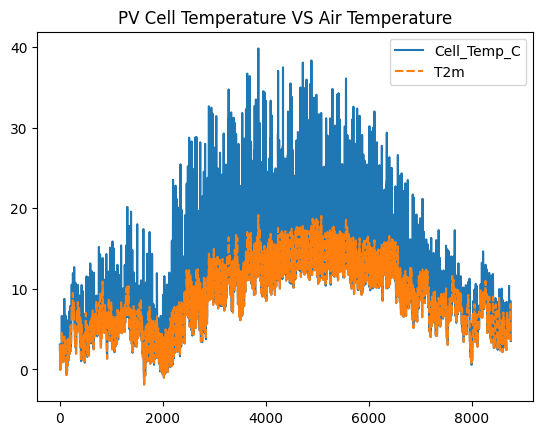

In [40]:
# Initialize the site object and obtain TMY data
testy_site = Site(latitude=54.60452, longitude=-5.92860)
testy_array_1 = [SolarPVArray(3.2, 35, 83)]
testy_pv_model = SolarPVModel(site=testy_site, arrays=testy_array_1)

sns.lineplot(testy_pv_model.models[0]["model_result"][["Cell_Temp_C", "T2m"]]).set_title("PV Cell Temperature VS Air Temperature")

# ***Example Running Model with variable inputs***

In [41]:
# Initialize the site object and obtain TMY data
site = Site(name="Test Site", address = "123 Test Street", client = "Big Gerry", 
            latitude=54.60452, longitude=-5.92860, tmz_hrs_east = 0)

2024-02-15 19:36:39,968 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-15 19:36:39,968 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-15 19:36:39,969 - INFO - *******************
2024-02-15 19:36:39,969 - INFO - *******************


In [42]:
# %%timeit

"""
    Current Hierarchy: Site --> SolarPVArray --> SolarPVModel
"""
pv_kwp = 1
surface_pitch = 35
surface_azimuth = 83

surface_azimuth_2 = -45
surface_azimuth_3 = 0
surface_azimuth_4 = 45

lifespan = 25
pv_eol_derating = 0.88
cost_per_kWp: float = 1250
electrical_eff: float = 0.21
cell_temp_coeff: float = -0.0035
transmittance_absorptance: float = 0.9

refraction_index:float = 0.1
cell_NOCT: float = 42
ambient_NOCT: float = 20
e_poa_NOCT: float = 800
e_poa_STC: float = 1000
cell_temp_STC: float = 25


# Initialize multiple PV array objects for more than one surface plane. First array is typical example
array_1 = SolarPVArray(pv_kwp, surface_pitch, surface_azimuth, lifespan, pv_eol_derating,
                       cost_per_kWp, electrical_eff, cell_temp_coeff, transmittance_absorptance)

array_2 = SolarPVArray(pv_kwp, surface_pitch, surface_azimuth_2)
array_3 = SolarPVArray(pv_kwp, surface_pitch, surface_azimuth_3)
array_4 = SolarPVArray(pv_kwp, surface_pitch, surface_azimuth_4)


# [array_1, array_2, array_3, array_4] , [array_1]
# Initialize and run the SolarPVModel with all arrays
arrays = [array_1, array_2, array_3, array_4]           
pv_model = SolarPVModel(site=site, arrays=arrays)

# pv_model.combined_results
# pv_model.save_model_csv()
# pv_model.array_model(3)
# pv_model.models
# pv_model.all_models
# pv_model.combined_models
# pv_models.summary
# pv_model.summary_grouped.daily

2024-02-15 19:36:39,981 - INFO - *******************
2024-02-15 19:36:39,981 - INFO - *******************
2024-02-15 19:36:39,982 - INFO - Starting model calculations for SolarPVModel.
2024-02-15 19:36:39,982 - INFO - Starting model calculations for SolarPVModel.
2024-02-15 19:36:39,983 - INFO - *******************
2024-02-15 19:36:39,983 - INFO - *******************
2024-02-15 19:36:39,984 - INFO - Simulating model for 1kWp, 35 degrees pitch & azimuth at 83 degrees WoS
2024-02-15 19:36:39,984 - INFO - Simulating model for 1kWp, 35 degrees pitch & azimuth at 83 degrees WoS
2024-02-15 19:36:40,013 - INFO - Simulating model for 1kWp, 35 degrees pitch & azimuth at -45 degrees WoS
2024-02-15 19:36:40,013 - INFO - Simulating model for 1kWp, 35 degrees pitch & azimuth at -45 degrees WoS
2024-02-15 19:36:40,044 - INFO - Simulating model for 1kWp, 35 degrees pitch & azimuth at 0 degrees WoS
2024-02-15 19:36:40,044 - INFO - Simulating model for 1kWp, 35 degrees pitch & azimuth at 0 degrees WoS


In [43]:
from plotly.offline import plot

pv_model.plot_sum(["T2m", "Cell_Temp_C_Avg"], group="daily", plot_type="bar")


In [44]:
pv_model.array_model(1).head()

,time(UTC),T2m,RH,G(h),Gb(n),Gd(h),IR(h),WS10m,WD10m,SP,...,E_Diffuse_kWm2,E_Ground_kWm2,E_POA_kWm2,Panel_POA_kWm2,IAM_Loss_kWm2,ET_HRad_kWm2,PV_Derated_Eff,Cell_Temp_C,PV_Gen_kWh,PV_Thermal_Loss_kWh
0,20090101:0000,3.07,87.29,0.0,0.0,0.0,306.29,5.70,102.0,102898.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3.07,0.0,0.0
1,20090101:0100,2.63,86.63,0.0,0.0,0.0,299.79,5.73,102.0,102901.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.63,0.0,0.0
2,20090101:0200,2.18,85.98,0.0,0.0,0.0,293.29,5.77,101.0,102905.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.18,0.0,0.0
3,20090101:0300,1.73,85.32,0.0,0.0,0.0,286.79,5.80,103.0,102898.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.73,0.0,0.0
4,20090101:0400,1.28,84.66,0.0,0.0,0.0,280.30,5.84,104.0,102891.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.28,0.0,0.0


In [45]:
pv_model.all_models.PV_Gen_kWh_Array_1.sum()

872.4531766551838

In [46]:
pv_model.all_models.E_POA_kWm2_Array_1.sum()

902.8271456765925

In [47]:
pv_model.summary_grouped.hourly.columns

Index(['PV_Gen_kWh_Total', 'E_POA_kWm2_Total', 'Panel_POA_kWm2_Total',
       'IAM_Loss_kWm2_Total', 'PV_Thermal_Loss_kWh_Total', 'E_Beam_kWm2_Total',
       'E_Diffuse_kWm2_Total', 'E_Ground_kWm2_Total', 'ET_HRad_kWm2_Total',
       'Cell_Temp_C_Avg', 'T2m'],
      dtype='object')

In [48]:
px.bar(pv_model.summary_grouped.hourly[["PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [49]:
px.bar(pv_model.summary_grouped.monthly[["PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [50]:
px.bar(pv_model.summary_grouped.weekly[["PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [51]:
px.bar(pv_model.summary_grouped.daily[["PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [52]:
px.bar(pv_model.summary_grouped.hourly[["E_POA_kWm2_Total", "Panel_POA_kWm2_Total", "PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [53]:
px.bar(pv_model.summary_grouped.monthly[["E_POA_kWm2_Total", "Panel_POA_kWm2_Total", "PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [54]:
px.line(pv_model.models[0]["model_result"][["Cell_Temp_C", "T2m"]])


In [55]:
px.line(pv_model.models[0]["model_result"][["ET_HRad_kWm2", "E_POA_kWm2"]])

# ***Mass Model Testing***

In [56]:
# %%timeit
import random

# Assuming the Site, SolarPVArray, and SolarPVModel classes are defined elsewhere
site = Site(name="Test Site", address="123 Test Street", client="Big Gerry", 
            latitude=54.60452, longitude=-5.92860, tmz_hrs_east=0)

surface_pitch = 35
azimuth_list = [90, 45, 0, -45, -90]
pv_eol = 0.88
cost = 1250
lifespan = 25
eff = 0.21
temp_coeff = -0.0048
t_ab = 0.9

max_pv = 7.5
min_pv = 2.5
pv_step_size = 0.25
pv_list = []
pv_models = {}

for i in range(int((max_pv - min_pv) / pv_step_size)):
    pv_list.append(min_pv + (i * pv_step_size))

for pv_size in pv_list:
    pv_kwp = pv_size

    array_1 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[0], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)
    array_2 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[1], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)
    array_3 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[2], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)
    array_4 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[3], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)
    array_5 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[4], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)

    # Initialize and run the SolarPVModel with all arrays
    arrays = [array_1, array_2, array_3, array_4, array_5]
    pv_model = SolarPVModel(site=site, arrays=arrays)

    pv_models[pv_size] = pv_model  # Store the model with pv_size as the key

Total_gen = 0

for model in pv_models.values():
    Total_gen += model.summary.PV_Gen_kWh_Annual

print("")
print("***************************************************")
print(f"{round(Total_gen / 1000, 3)} MWh from {len(pv_list)} models simulating {len(pv_list) * 5} PV arrays in total.")


2024-02-15 19:36:40,685 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-15 19:36:40,685 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-15 19:36:40,686 - INFO - *******************
2024-02-15 19:36:40,686 - INFO - *******************
2024-02-15 19:36:40,722 - INFO - *******************
2024-02-15 19:36:40,722 - INFO - *******************
2024-02-15 19:36:40,723 - INFO - Starting model calculations for SolarPVModel.
2024-02-15 19:36:40,723 - INFO - Starting model calculations for SolarPVModel.
2024-02-15 19:36:40,724 - INFO - *******************
2024-02-15 19:36:40,724 - INFO - *******************
2024-02-15 19:36:40,725 - INFO - Simulating model for 2.5kWp, 35 degrees pitch & azimuth at 90 degrees WoS
2024-02-15 19:36:40,725 - INFO - Simulating model for 2.5kWp, 35 degrees pitch & azimuth at 90 degrees WoS
2024-02-15 19:36:40,766 - INFO - Simulating model for 2.5kWp, 35 degrees pitch & azimuth at 45 degrees WoS
2024-02-15 19:36:40,766 - INFO - 


***************************************************
450.57 MWh from 20 models simulating 100 PV arrays in total.


In [57]:
pv_models.get(2.5).models[0]["model_result"]

,time(UTC),T2m,RH,G(h),Gb(n),Gd(h),IR(h),WS10m,WD10m,SP,...,E_Diffuse_kWm2,E_Ground_kWm2,E_POA_kWm2,Panel_POA_kWm2,IAM_Loss_kWm2,ET_HRad_kWm2,PV_Derated_Eff,Cell_Temp_C,PV_Gen_kWh,PV_Thermal_Loss_kWh
0,20090101:0000,3.07,87.29,0.0,0.0,0.0,306.29,5.70,102.0,102898.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3.07,0.0,0.0
1,20090101:0100,2.63,86.63,0.0,0.0,0.0,299.79,5.73,102.0,102901.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.63,0.0,0.0
2,20090101:0200,2.18,85.98,0.0,0.0,0.0,293.29,5.77,101.0,102905.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.18,0.0,0.0
3,20090101:0300,1.73,85.32,0.0,0.0,0.0,286.79,5.80,103.0,102898.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.73,0.0,0.0
4,20090101:0400,1.28,84.66,0.0,0.0,0.0,280.30,5.84,104.0,102891.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.28,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,20131231:1900,5.31,90.58,0.0,0.0,0.0,338.77,5.52,246.0,97176.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995203,5.31,0.0,0.0
8756,20131231:2000,4.86,89.92,0.0,0.0,0.0,332.28,5.55,259.0,97289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995202,4.86,0.0,0.0
8757,20131231:2100,4.41,89.26,0.0,0.0,0.0,325.78,5.59,263.0,97399.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995202,4.41,0.0,0.0
8758,20131231:2200,3.97,88.61,0.0,0.0,0.0,319.28,5.63,266.0,97509.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995201,3.97,0.0,0.0


In [58]:
# Access values from dictionary
pv_models.get(2.5).summary_grouped.daily.PV_Gen_kWh_Total.sum()

11553.074

2024-02-15 19:36:45,199 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:45,199 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:45,203 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:45,203 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Month_of_Year'>

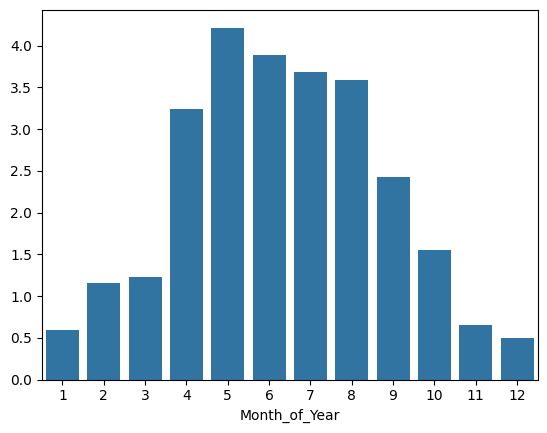

In [59]:
sns.barplot(pv_models.get(2.5).summary_grouped.monthly.Cell_Temp_C_Avg - pv_models.get(2.5).summary_grouped.monthly.T2m)

2024-02-15 19:36:45,334 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:45,334 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:45,339 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-02-15 19:36:45,339 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


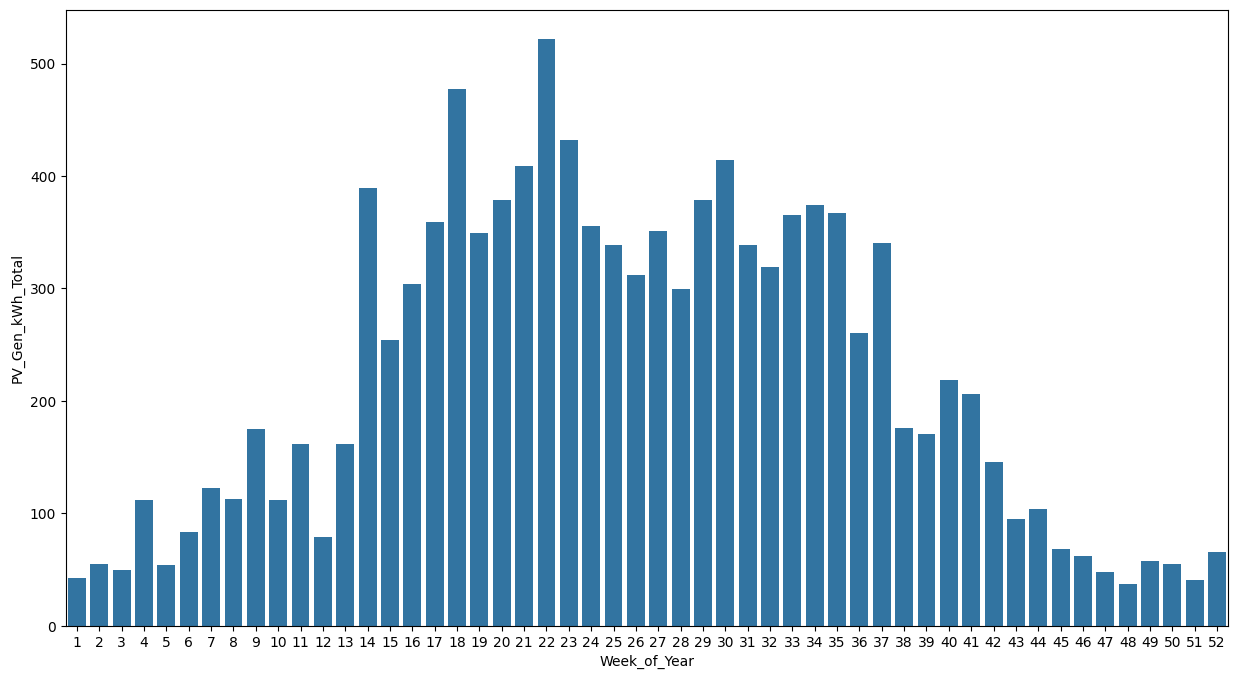

In [60]:
sns.barplot(pv_models.get(2.5).summary_grouped.weekly.PV_Gen_kWh_Total)
plt.gcf().set_size_inches(15, 8)

2024-02-15 19:36:45,661 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:45,661 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:45,667 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:45,667 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


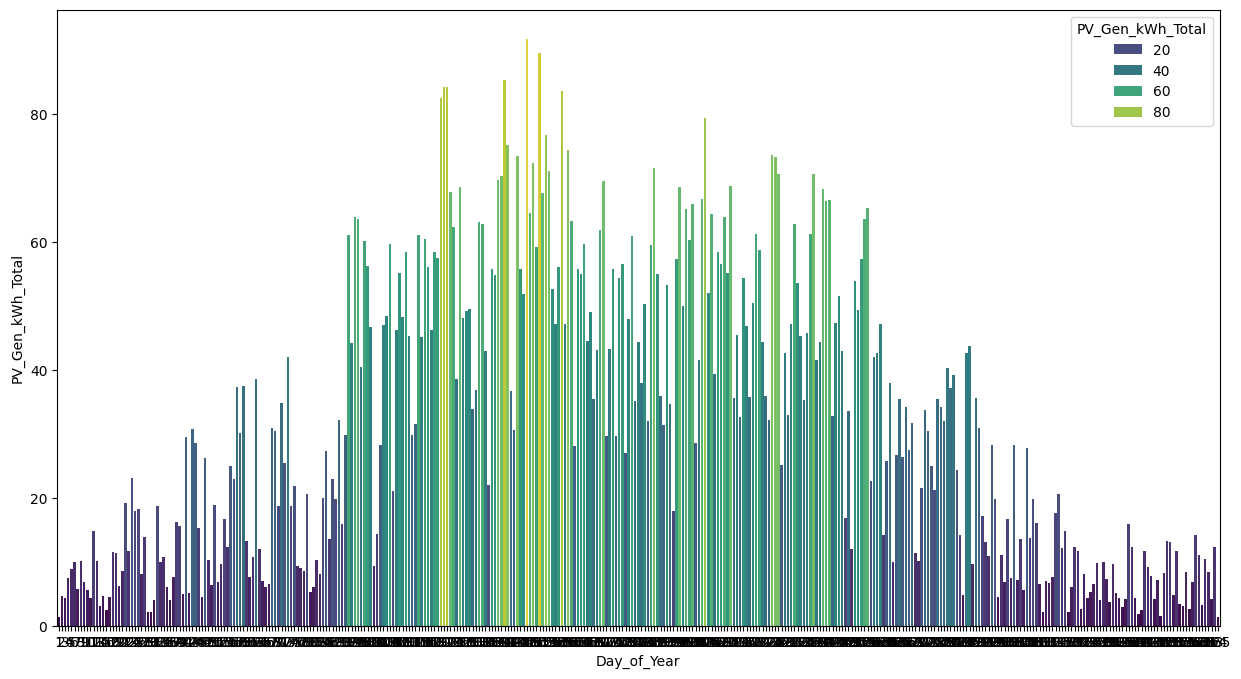

In [61]:
sns.barplot(data=pv_models.get(2.5).summary_grouped.daily, x="Day_of_Year", y="PV_Gen_kWh_Total", 
            hue="PV_Gen_kWh_Total", palette="viridis")

plt.gcf().set_size_inches(15, 8)

In [62]:
for pv_size in pv_list:
    print(f"{round(pv_models.get(pv_size).summary_grouped.daily.PV_Gen_kWh_Total.sum() / 1000, 3)} MWh/yr")

11.553 MWh/yr
12.708 MWh/yr
13.864 MWh/yr
15.019 MWh/yr
16.174 MWh/yr
17.33 MWh/yr
18.485 MWh/yr
19.64 MWh/yr
20.796 MWh/yr
21.951 MWh/yr
23.106 MWh/yr
24.261 MWh/yr
25.417 MWh/yr
26.572 MWh/yr
27.727 MWh/yr
28.883 MWh/yr
30.038 MWh/yr
31.193 MWh/yr
32.349 MWh/yr
33.504 MWh/yr


# ***VISUAL TESTING***

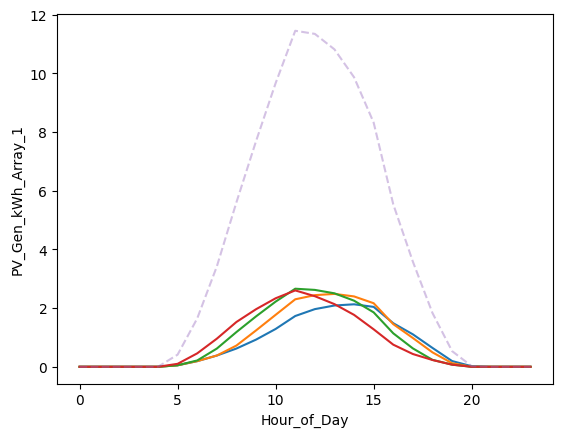

In [63]:
variables = ['E_Beam_Wm2', 'E_Diffuse_Wm2', 'E_Ground_Wm2', 'E_POA_Wm2', 'ET_HRad_Wm2', 
            'Cell_Temp_C', 'PV_Gen_kWh', 'AOI', 'Zenith_Angle']

testy = pv_model.all_models

variable = "PV_Gen_kWh"

variable_1 = f"{variable}_Array_1"
variable_2 = f"{variable}_Array_2"
variable_3 = f"{variable}_Array_3"
variable_4 = f"{variable}_Array_4"
variable_7 = f"{variable}_Total"
variable_8 = f"{variable}_Avg"

if variable_1 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_1].mean())
if variable_2 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_2].mean())
if variable_3 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_3].mean())
if variable_4 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_4].mean())
if variable_7 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_7].mean(), alpha=0.4, ls="--")
if variable_8 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_8].mean(), alpha=0.4, ls="--")

<Axes: ylabel='Cell_Temp_C_Avg'>

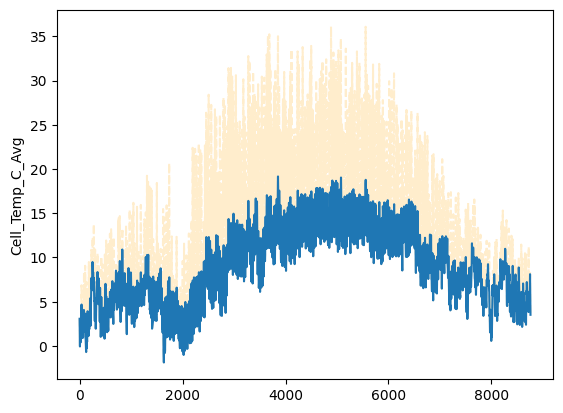

In [64]:
sns.lineplot(pv_model.combined_model["Cell_Temp_C_Avg"], alpha = 0.2, ls = "--", color = "orange")
sns.lineplot(pv_model.combined_model["T2m"])

2024-02-15 19:36:48,843 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:48,843 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:48,848 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-15 19:36:48,848 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Day_of_Year', ylabel='T2m'>

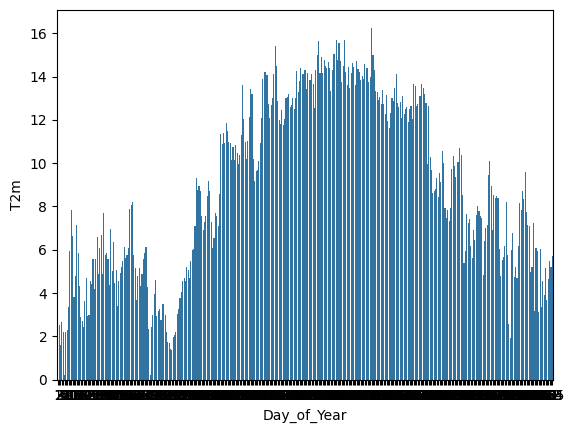

In [65]:
sns.barplot(pv_model.summary_grouped.daily.T2m)

<Axes: xlabel='Hour_of_Day', ylabel='PV_Gen_kWh_Total'>

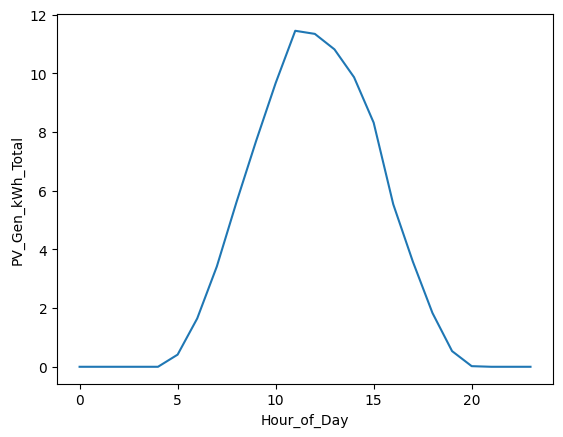

In [66]:
sns.lineplot(pv_model.combined_model.groupby("Hour_of_Day")["PV_Gen_kWh_Total"].mean())

In [67]:
pv_model.all_models["PV_Gen_kWh_Total"].sum()

33503.90540087376

In [68]:
testytest = pv_model.all_models


In [69]:
filtered_columns = [col for col in testytest.columns if col.startswith('PV_Gen_kWh_Array_')]

In [70]:
testytesty = testytest[filtered_columns].sum()

In [71]:
testytesty[testytesty == testytesty.min()]

PV_Gen_kWh_Array_5    6095.935291
dtype: float64

In [72]:
pv_model.all_models.columns

Index(['E_Beam_kWm2_Array_1', 'E_Diffuse_kWm2_Array_1',
       'E_Ground_kWm2_Array_1', 'E_POA_kWm2_Array_1', 'Panel_POA_kWm2_Array_1',
       'ET_HRad_kWm2_Array_1', 'Cell_Temp_C_Array_1', 'PV_Gen_kWh_Array_1',
       'PV_Thermal_Loss_kWh_Array_1', 'IAM_Loss_kWm2_Array_1', 'AOI_Array_1',
       'Zenith_Angle_Array_1', 'E_Beam_kWm2_Array_2', 'E_Diffuse_kWm2_Array_2',
       'E_Ground_kWm2_Array_2', 'E_POA_kWm2_Array_2', 'Panel_POA_kWm2_Array_2',
       'ET_HRad_kWm2_Array_2', 'Cell_Temp_C_Array_2', 'PV_Gen_kWh_Array_2',
       'PV_Thermal_Loss_kWh_Array_2', 'IAM_Loss_kWm2_Array_2', 'AOI_Array_2',
       'Zenith_Angle_Array_2', 'E_Beam_kWm2_Array_3', 'E_Diffuse_kWm2_Array_3',
       'E_Ground_kWm2_Array_3', 'E_POA_kWm2_Array_3', 'Panel_POA_kWm2_Array_3',
       'ET_HRad_kWm2_Array_3', 'Cell_Temp_C_Array_3', 'PV_Gen_kWh_Array_3',
       'PV_Thermal_Loss_kWh_Array_3', 'IAM_Loss_kWm2_Array_3', 'AOI_Array_3',
       'Zenith_Angle_Array_3', 'E_Beam_kWm2_Array_4', 'E_Diffuse_kWm2_Array_4',
  

In [73]:
pv_model.all_models["PV_Gen_kWh_Total"].sum()

33503.90540087376

<Axes: ylabel='PV_Thermal_Loss_kWh_Total'>

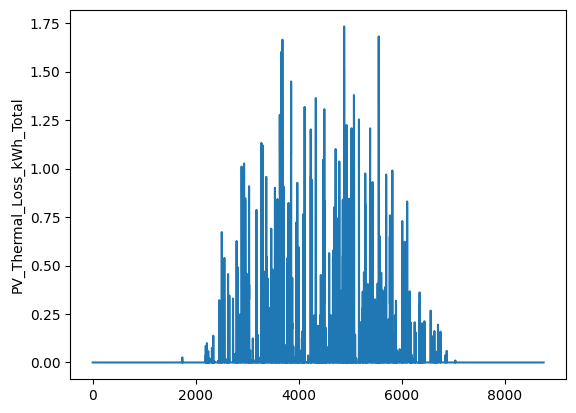

In [74]:
sns.lineplot(pv_model.all_models["PV_Thermal_Loss_kWh_Total"])

In [75]:
temp_losses = (pv_model.all_models["PV_Thermal_Loss_kWh_Total"].sum() / pv_model.all_models["PV_Thermal_Loss_kWh_Total"].sum() * 100)

print(f"{round(temp_losses, 3)}% change to power due to temperature losses")

100.0% change to power due to temperature losses


In [76]:
pv_model.all_models

,E_Beam_kWm2_Array_1,E_Diffuse_kWm2_Array_1,E_Ground_kWm2_Array_1,E_POA_kWm2_Array_1,Panel_POA_kWm2_Array_1,ET_HRad_kWm2_Array_1,Cell_Temp_C_Array_1,PV_Gen_kWh_Array_1,PV_Thermal_Loss_kWh_Array_1,IAM_Loss_kWm2_Array_1,...,PV_Thermal_Loss_kWh_Total,IAM_Loss_kWm2_Total,Declination_Angle,Solar_Time,Hour_Angle,T2m,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year
0,0.0,0.0,0.0,0.0,0.0,0.0,3.07,0.0,0.0,0.0,...,0.0,0.0,-23.011637,0.056353,-179.154706,3.07,0,1,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0,0.0,...,0.0,0.0,-23.011637,1.056353,-164.154706,2.63,1,1,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,2.18,0.0,0.0,0.0,...,0.0,0.0,-23.011637,2.056353,-149.154706,2.18,2,1,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.73,0.0,0.0,0.0,...,0.0,0.0,-23.011637,3.056353,-134.154706,1.73,3,1,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.28,0.0,0.0,0.0,...,0.0,0.0,-23.011637,4.056353,-119.154706,1.28,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,0.0,0.0,0.0,0.0,0.0,5.31,0.0,0.0,0.0,...,0.0,0.0,-23.085911,19.063871,105.958063,5.31,19,365,52,12
8756,0.0,0.0,0.0,0.0,0.0,0.0,4.86,0.0,0.0,0.0,...,0.0,0.0,-23.085911,20.063871,120.958063,4.86,20,365,52,12
8757,0.0,0.0,0.0,0.0,0.0,0.0,4.41,0.0,0.0,0.0,...,0.0,0.0,-23.085911,21.063871,135.958063,4.41,21,365,52,12
8758,0.0,0.0,0.0,0.0,0.0,0.0,3.97,0.0,0.0,0.0,...,0.0,0.0,-23.085911,22.063871,150.958063,3.97,22,365,52,12


# ***MODEL ANALYSIS***

# ***PLOTLY***